<a href="https://colab.research.google.com/github/tumblingdice512/Research/blob/master/model5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [125]:
import torch
import torch.nn.functional as f
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [126]:
N = 10
L = 5

In [127]:
torch.manual_seed(100)

In [128]:
S0 = torch.sign(torch.randn(5,N))

SL = torch.sign(torch.randn(5,N))


M = S0.size()[0]
print(M)
print(N)
print(S0.shape)
print(S0[0].shape)

5
10
torch.Size([5, 10])
torch.Size([10])


In [129]:
alpha = M / N
print(alpha)

0.5


In [130]:
D = torch.tensor([[1,2,3],[2,3,4]])
print(D)
print(D.shape)
print("M:",D.size()[0]) #M
print("N:",D.size()[1]) #N

tensor([[1, 2, 3],
        [2, 3, 4]])
torch.Size([2, 3])
M: 2
N: 3


In [131]:
def spin_overlap(x,y):
  spin_overlap = 0
  for i in range (len(x[0])) :

    spin_overlap = spin_overlap + torch.dot(x.T[i],y.T[i])
  return torch.abs(spin_overlap/(x.size()[0]*x.size()[1]))

print(spin_overlap(S0,S0))


tensor(1.)


In [132]:
def bond_overlap(x,y):
  bond_overlap = 0
  for i in range (len(x[0])) :

    bond_overlap = bond_overlap + torch.dot(x[i],y[i])
  return torch.abs(bond_overlap/(x.size()[0]*x.size()[1]))

#pytorchではネットワークで定義する重みの転置を計算に用いるので、行方向が同じパーセプトロンに対応

In [133]:
S_a = torch.Tensor([[1,-1],[-1,1],[1,-1]])
S_b = torch.Tensor([[1,-1],[1,1],[1,1]])
print(spin_overlap(S_a,S_b))
print(spin_overlap(S_a,S_a))

tensor(0.3333)
tensor(1.)


In [134]:
a1 = torch.dot(S_a.T[0],S_b.T[0])
a2 = torch.dot(S_a.T[1],S_b.T[1])
a3 = (a1 + a2)/(2*3)
print(a3)

tensor(0.3333)


In [135]:
def MSE(t, y):
    mse = torch.mean(torch.sum(torch.square(t-y),axis = 1),axis = 0)
    return mse

In [136]:
print(MSE(S0,SL))

tensor(18.4000)


In [137]:
A = torch.Tensor([[3,5,1],[4,12,1]])
print(A**2)
A_norm = (torch.sum(torch.square(A),axis=0))**(1/2)

A_normalized = A / A_norm
A_normalized_2 = A / A_norm * (N**(1/2))

print(A_norm)

print(A_normalized)
print(A_normalized_2)

tensor([[  9.,  25.,   1.],
        [ 16., 144.,   1.]])
tensor([ 5.0000, 13.0000,  1.4142])
tensor([[0.6000, 0.3846, 0.7071],
        [0.8000, 0.9231, 0.7071]])
tensor([[1.8974, 1.2163, 2.2361],
        [2.5298, 2.9190, 2.2361]])


In [138]:
def weight_norm(x):
    x_norm = (torch.sum(torch.square(x),axis=0)**(1/2))
    return x_norm

In [139]:
w_a = torch.Tensor([[1,0,1],[1,2,0],[0,1,0]]) 
w_b = torch.Tensor([[1,0,0],[0,1,0],[0,0,1]]) 
J_a = w_a / (weight_norm(w_a)) * (3**(1/2))
J_b = w_b / (weight_norm(w_b)) * (3**(1/2))


print(J_a)
print(J_b)
print(len(J_a[0]))

print(bond_overlap(J_a,J_b))
print(bond_overlap(J_a,J_a))

tensor([[1.2247, 0.0000, 1.7321],
        [1.2247, 1.5492, 0.0000],
        [0.0000, 0.7746, 0.0000]])
tensor([[1.7321, 0.0000, 0.0000],
        [0.0000, 1.7321, 0.0000],
        [0.0000, 0.0000, 1.7321]])
3
tensor(0.5338)
tensor(1.)


In [140]:
c = torch.nn.utils.weight_norm(torch.nn.Linear(4, 3, False), name='weight',dim=0)
#計算の際にはcの転置を用いる。正規化は、dim=0で行う必要あり。
print(c.weight)
print(c.weight_g)
d = c.weight/c.weight_g
print(d)
print(c.weight_v.size())

tensor([[-0.3121,  0.0534, -0.2318,  0.4556],
        [ 0.4761,  0.0934, -0.1876,  0.4431],
        [ 0.3519,  0.4815, -0.3868, -0.0217]], grad_fn=<MulBackward0>)
Parameter containing:
tensor([[0.6013],
        [0.6834],
        [0.7112]], requires_grad=True)
tensor([[-0.5190,  0.0888, -0.3856,  0.7577],
        [ 0.6967,  0.1366, -0.2745,  0.6485],
        [ 0.4948,  0.6771, -0.5439, -0.0305]], grad_fn=<DivBackward0>)
torch.Size([3, 4])


In [141]:
e = torch.nn.utils.weight_norm(torch.nn.Linear(4, 3, False), name='weight',dim=0)
print(e.weight)
print(e.weight_g)
x = torch.randn(2, 4)
print("x",x)
print("e(x)",e(x))
e.weight = e.weight/e.weight_g
print(e.weight)
print("3*e(x)",3*e(x))


tensor([[-0.0564, -0.1153, -0.0479,  0.0569],
        [ 0.4952, -0.4985, -0.4187, -0.0093],
        [-0.2870, -0.0397, -0.3614, -0.4723]], grad_fn=<MulBackward0>)
Parameter containing:
tensor([[0.1483],
        [0.8180],
        [0.6615]], requires_grad=True)
x tensor([[-0.7347, -0.1396,  0.2408, -0.5533],
        [-2.0483,  1.1918,  0.8283,  0.1775]])
e(x) tensor([[ 0.0145, -0.3900,  0.3907],
        [-0.0515, -1.9569,  0.1574]], grad_fn=<MmBackward>)
tensor([[-0.3800, -0.7773, -0.3231,  0.3834],
        [ 0.6054, -0.6094, -0.5119, -0.0113],
        [-0.4339, -0.0600, -0.5463, -0.7140]], grad_fn=<DivBackward0>)
3*e(x) tensor([[ 0.0435, -1.1700,  1.1721],
        [-0.1546, -5.8708,  0.4722]], grad_fn=<MulBackward0>)


In [158]:
class Network1(torch.nn.Module):
    def __init__(self):
        super(Network1, self).__init__()
        self.fc1_1 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)
        self.fc2_1 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)
        self.fc3_1 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)
        self.fc4_1 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)
        self.fc5_1 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)

        
    def forward(self, x):
        x = torch.tanh(N**(1/2)*self.fc1_1(x))
        S1_1 = torch.sign(x)
        x = torch.tanh(N**(1/2)*self.fc2_1(x))
        S2_1 = torch.sign(x)
        x = torch.tanh(N**(1/2)*self.fc3_1(x))
        S3_1 = torch.sign(x)
        x = torch.tanh(N**(1/2)*self.fc4_1(x))
        S4_1 = torch.sign(x)
        x = torch.tanh(N**(1/2)*self.fc5_1(x))
        S5_1 = torch.sign(x)

        return x, S1_1, S2_1, S3_1, S4_1, S5_1, self.fc1_1, self.fc2_1, self.fc3_1, self.fc4_1, self.fc5_1, self.fc1_1.weight_g, self.fc2_1.weight_g, self.fc3_1.weight_g, self.fc4_1.weight_g, self.fc5_1.weight_g



In [159]:
class Network2(torch.nn.Module):
    def __init__(self):
        super(Network2, self).__init__()
        self.fc1_2 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)
        self.fc2_2 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)
        self.fc3_2 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)
        self.fc4_2 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)
        self.fc5_2 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)

        

        
    def forward(self, x):

        x = torch.tanh(N**(1/2)*self.fc1_2(x))
        S1_2 = torch.sign(x)
        x = torch.tanh(N**(1/2)*self.fc2_2(x))
        S2_2 = torch.sign(x)
        x = torch.tanh(N**(1/2)*self.fc3_2(x))
        S3_2 = torch.sign(x)
        x = torch.tanh(N**(1/2)*self.fc4_2(x))
        S4_2 = torch.sign(x)
        x = torch.tanh(N**(1/2)*self.fc5_2(x))
        S5_2 = torch.sign(x)

        return x, S1_2, S2_2, S3_2, S4_2, S5_2, self.fc1_2, self.fc2_2, self.fc3_2, self.fc4_2, self.fc5_2, self.fc1_2.weight_g, self.fc2_2.weight_g, self.fc3_2.weight_g, self.fc4_2.weight_g, self.fc5_2.weight_g



In [160]:
class Network3(torch.nn.Module):
    def __init__(self):
        super(Network3, self).__init__()
        self.fc1_3 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)
        self.fc2_3 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)
        self.fc3_3 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)
        self.fc4_3 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)
        self.fc5_3 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)

        

        
    def forward(self, x):

        x = torch.tanh(N**(1/2)*self.fc1_3(x))
        S1_3 = torch.sign(x)
        x = torch.tanh(N**(1/2)*self.fc2_3(x))
        S2_3 = torch.sign(x)
        x = torch.tanh(N**(1/2)*self.fc3_3(x))
        S3_3 = torch.sign(x)
        x = torch.tanh(N**(1/2)*self.fc4_3(x))
        S4_3 = torch.sign(x)
        x = torch.tanh(N**(1/2)*self.fc5_3(x))
        S5_3 = torch.sign(x)

        return x, S1_3, S2_3, S3_3, S4_3, S5_3, self.fc1_3, self.fc2_3, self.fc3_3, self.fc4_3, self.fc5_3, self.fc1_3.weight_g, self.fc2_3.weight_g, self.fc3_3.weight_g, self.fc4_3.weight_g, self.fc5_3.weight_g



In [161]:
class Network4(torch.nn.Module):
    def __init__(self):
        super(Network4, self).__init__()
        self.fc1_4 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)
        self.fc2_4 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)
        self.fc3_4 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)
        self.fc4_4 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)
        self.fc5_4 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)

        

        
    def forward(self, x):

        x = torch.tanh(N**(1/2)*self.fc1_4(x))
        S1_4 = torch.sign(x)
        x = torch.tanh(N**(1/2)*self.fc2_4(x))
        S2_4 = torch.sign(x)
        x = torch.tanh(N**(1/2)*self.fc3_4(x))
        S3_4 = torch.sign(x)
        x = torch.tanh(N**(1/2)*self.fc4_4(x))
        S4_4 = torch.sign(x)
        x = torch.tanh(N**(1/2)*self.fc5_4(x))
        S5_4 = torch.sign(x)

        return x, S1_4, S2_4, S3_4, S4_4, S5_4, self.fc1_4, self.fc2_4, self.fc3_4, self.fc4_4, self.fc5_4, self.fc1_4.weight_g, self.fc2_4.weight_g, self.fc3_4.weight_g, self.fc4_4.weight_g, self.fc5_4.weight_g



In [162]:
class Network5(torch.nn.Module):
    def __init__(self):
        super(Network5, self).__init__()
        self.fc1_5 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)
        self.fc2_5 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)
        self.fc3_5 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)
        self.fc4_5 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)
        self.fc5_5 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)

        

        
    def forward(self, x):

        x = torch.tanh(N**(1/2)*self.fc1_5(x))
        S1_5 = torch.sign(x)
        x = torch.tanh(N**(1/2)*self.fc2_5(x))
        S2_5 = torch.sign(x)
        x = torch.tanh(N**(1/2)*self.fc3_5(x))
        S3_5 = torch.sign(x)
        x = torch.tanh(N**(1/2)*self.fc4_5(x))
        S4_5 = torch.sign(x)
        x = torch.tanh(N**(1/2)*self.fc5_5(x))
        S5_5 = torch.sign(x)

        return x, S1_5, S2_5, S3_5, S4_5, S5_5, self.fc1_5, self.fc2_5, self.fc3_5, self.fc4_5, self.fc5_5, self.fc1_5.weight_g, self.fc2_5.weight_g, self.fc3_5.weight_g, self.fc4_5.weight_g, self.fc5_5.weight_g



In [163]:
class Network6(torch.nn.Module):
    def __init__(self):
        super(Network6, self).__init__()
        self.fc1_6 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)
        self.fc2_6 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)
        self.fc3_6 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)
        self.fc4_6 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)
        self.fc5_6 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)

        

        
    def forward(self, x):

        x = torch.tanh(N**(1/2)*self.fc1_6(x))
        S1_6 = torch.sign(x)
        x = torch.tanh(N**(1/2)*self.fc2_6(x))
        S2_6 = torch.sign(x)
        x = torch.tanh(N**(1/2)*self.fc3_6(x))
        S3_6 = torch.sign(x)
        x = torch.tanh(N**(1/2)*self.fc4_6(x))
        S4_6 = torch.sign(x)
        x = torch.tanh(N**(1/2)*self.fc5_6(x))
        S5_6 = torch.sign(x)

        return x, S1_6, S2_6, S3_6, S4_6, S5_6, self.fc1_6, self.fc2_6, self.fc3_6, self.fc4_6, self.fc5_6, self.fc1_6.weight_g, self.fc2_6.weight_g, self.fc3_6.weight_g, self.fc4_6.weight_g, self.fc5_6.weight_g



In [164]:
if __name__ == '__main__':
    # 学習回数
    n_epoch = 10000
 
    # 学習結果の保存用
    history_1 = {'train_loss_1': [],'train_loss_2': [],'train_loss_3': [],
                 'train_loss_4': [],'train_loss_5': [],'train_loss_6': []}

  
 
    # ネットワークを構築
    net_1: torch.nn.Module = Network1()
    net_2: torch.nn.Module = Network2()
    net_3: torch.nn.Module = Network3()
    net_4: torch.nn.Module = Network4()
    net_5: torch.nn.Module = Network5()
    net_6: torch.nn.Module = Network6()
    
    optimizer_1 = torch.optim.SGD(params=net_1.parameters(), lr=0.05)
    optimizer_2 = torch.optim.SGD(params=net_2.parameters(), lr=0.05)
    optimizer_3 = torch.optim.SGD(params=net_3.parameters(), lr=0.05)
    optimizer_4 = torch.optim.SGD(params=net_4.parameters(), lr=0.05)
    optimizer_5 = torch.optim.SGD(params=net_5.parameters(), lr=0.05)
    optimizer_6 = torch.optim.SGD(params=net_6.parameters(), lr=0.05)

    for n in range(n_epoch):
 
        """ Training Part"""
        loss = None
        # 学習フェーズ
        net_1.train(True)  # 引数は省略可能
        net_2.train(True)
        net_3.train(True)
        net_4.train(True)
        net_5.train(True)
        net_6.train(True)
        
 
        optimizer_1.zero_grad()
        optimizer_2.zero_grad()
        optimizer_3.zero_grad()
        optimizer_4.zero_grad()
        optimizer_5.zero_grad()
        optimizer_6.zero_grad()

        output_1 = net_1(S0)
        output_2 = net_2(S0)
        output_3 = net_3(S0)
        output_4 = net_4(S0)
        output_5 = net_5(S0)
        output_6 = net_6(S0)

        loss_1 = MSE(output_1[0], SL)
        loss_2 = MSE(output_2[0], SL)
        loss_3 = MSE(output_3[0], SL)
        loss_4 = MSE(output_4[0], SL)
        loss_5 = MSE(output_5[0], SL)
        loss_6 = MSE(output_6[0], SL)

        loss_1.backward()
        loss_2.backward()
        loss_3.backward()
        loss_4.backward()
        loss_5.backward()
        loss_6.backward()

        optimizer_1.step()
        optimizer_2.step()
        optimizer_3.step()
        optimizer_4.step()
        optimizer_5.step()
        optimizer_6.step()

        history_1['train_loss_1'].append(loss_1)
        history_1['train_loss_2'].append(loss_2)
        history_1['train_loss_3'].append(loss_3)
        history_1['train_loss_4'].append(loss_4)
        history_1['train_loss_5'].append(loss_5)
        history_1['train_loss_6'].append(loss_6)
 
        if n % 1000 == 0 or n == n_epoch-1
          print('EPOCH ', n + 1, ' | train_loss_1 ',loss_1, ' | train_loss_2 ',loss_2, ' | train_loss_3 ',loss_3
              , ' | train_loss_4 ',loss_4, ' | train_loss_5 ',loss_5, ' | train_loss_6 ',loss_6)
        
        if not n == n_epoch-1:
          del loss_1, loss_2, loss_3, loss_4, loss_5, loss_6
          del output_1, output_2, output_3 ,output_4, output_5, output_6
        

EPOCH  1  | train_loss_1  tensor(13.8822, grad_fn=<MeanBackward1>)  | train_loss_2  tensor(13.9222, grad_fn=<MeanBackward1>)  | train_loss_3  tensor(16.8050, grad_fn=<MeanBackward1>)  | train_loss_4  tensor(16.7526, grad_fn=<MeanBackward1>)  | train_loss_5  tensor(14.3517, grad_fn=<MeanBackward1>)  | train_loss_6  tensor(17.4345, grad_fn=<MeanBackward1>)
EPOCH  1001  | train_loss_1  tensor(0.0008, grad_fn=<MeanBackward1>)  | train_loss_2  tensor(0.0009, grad_fn=<MeanBackward1>)  | train_loss_3  tensor(0.0009, grad_fn=<MeanBackward1>)  | train_loss_4  tensor(0.0010, grad_fn=<MeanBackward1>)  | train_loss_5  tensor(0.0009, grad_fn=<MeanBackward1>)  | train_loss_6  tensor(0.0009, grad_fn=<MeanBackward1>)
EPOCH  2001  | train_loss_1  tensor(0.0004, grad_fn=<MeanBackward1>)  | train_loss_2  tensor(0.0004, grad_fn=<MeanBackward1>)  | train_loss_3  tensor(0.0004, grad_fn=<MeanBackward1>)  | train_loss_4  tensor(0.0005, grad_fn=<MeanBackward1>)  | train_loss_5  tensor(0.0004, grad_fn=<MeanBack

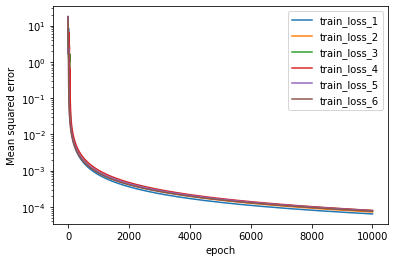

In [165]:
# 結果の出力と描画
plt.figure()
plt.plot(range(1, n_epoch+1), history_1['train_loss_1'], label='train_loss_1')
plt.plot(range(1, n_epoch+1), history_1['train_loss_2'], label='train_loss_2')
plt.plot(range(1, n_epoch+1), history_1['train_loss_3'], label='train_loss_3')
plt.plot(range(1, n_epoch+1), history_1['train_loss_4'], label='train_loss_4')
plt.plot(range(1, n_epoch+1), history_1['train_loss_5'], label='train_loss_5')
plt.plot(range(1, n_epoch+1), history_1['train_loss_6'], label='train_loss_6')
plt.xlabel('epoch')
plt.ylabel('Mean squared error')
plt.legend()
plt.yscale("log")
plt.savefig('loss.png')



In [166]:
print('レプリカ1の出力と正解のオーバーラップ',spin_overlap(output_1[5], SL))
print('レプリカ2の出力と正解のオーバーラップ',spin_overlap(output_2[5], SL))
print('レプリカ3の出力と正解のオーバーラップ',spin_overlap(output_3[5], SL))
print('レプリカ4の出力と正解のオーバーラップ',spin_overlap(output_4[5], SL))
print('レプリカ5の出力と正解のオーバーラップ',spin_overlap(output_5[5], SL))
print('レプリカ6の出力と正解のオーバーラップ',spin_overlap(output_6[5], SL))

レプリカ1の出力と正解のオーバーラップ tensor(1., grad_fn=<AbsBackward>)
レプリカ2の出力と正解のオーバーラップ tensor(1., grad_fn=<AbsBackward>)
レプリカ3の出力と正解のオーバーラップ tensor(1., grad_fn=<AbsBackward>)
レプリカ4の出力と正解のオーバーラップ tensor(1., grad_fn=<AbsBackward>)
レプリカ5の出力と正解のオーバーラップ tensor(1., grad_fn=<AbsBackward>)
レプリカ6の出力と正解のオーバーラップ tensor(1., grad_fn=<AbsBackward>)


In [167]:
J1_1 = N**(1/2) * output_1[6].weight/output_1[11]
J2_1 = N**(1/2) * output_1[7].weight/output_1[12]
J3_1 = N**(1/2) * output_1[8].weight/output_1[13]
J4_1 = N**(1/2) * output_1[9].weight/output_1[14]
J5_1 = N**(1/2) * output_1[10].weight/output_1[15]

S1_1 = output_1[1]
S2_1 = output_1[2]
S3_1 = output_1[3]
S4_1 = output_1[4]
S5_1 = output_1[5]



In [168]:
J1_2 = N**(1/2) * output_2[6].weight/output_2[11]
J2_2 = N**(1/2) * output_2[7].weight/output_2[12]
J3_2 = N**(1/2) * output_2[8].weight/output_2[13]
J4_2 = N**(1/2) * output_2[9].weight/output_2[14]
J5_2 = N**(1/2) * output_2[10].weight/output_2[15]

S1_2 = output_2[1]
S2_2 = output_2[2]
S3_2 = output_2[3]
S4_2 = output_2[4]
S5_2 = output_2[5]

In [169]:
J1_3 = N**(1/2) * output_3[6].weight/output_3[11]
J2_3 = N**(1/2) * output_3[7].weight/output_3[12]
J3_3 = N**(1/2) * output_3[8].weight/output_3[13]
J4_3 = N**(1/2) * output_3[9].weight/output_3[14]
J5_3 = N**(1/2) * output_3[10].weight/output_3[15]

S1_3 = output_3[1]
S2_3 = output_3[2]
S3_3 = output_3[3]
S4_3 = output_3[4]
S5_3 = output_3[5]

In [170]:
J1_4 = N**(1/2) * output_4[6].weight/output_4[11]
J2_4 = N**(1/2) * output_4[7].weight/output_4[12]
J3_4 = N**(1/2) * output_4[8].weight/output_4[13]
J4_4 = N**(1/2) * output_4[9].weight/output_4[14]
J5_4 = N**(1/2) * output_4[10].weight/output_4[15]

S1_4 = output_4[1]
S2_4 = output_4[2]
S3_4 = output_4[3]
S4_4 = output_4[4]
S5_4 = output_4[5]

In [171]:
J1_5 = N**(1/2) * output_5[6].weight/output_5[11]
J2_5 = N**(1/2) * output_5[7].weight/output_5[12]
J3_5 = N**(1/2) * output_5[8].weight/output_5[13]
J4_5 = N**(1/2) * output_5[9].weight/output_5[14]
J5_5 = N**(1/2) * output_5[10].weight/output_5[15]

S1_5 = output_5[1]
S2_5 = output_5[2]
S3_5 = output_5[3]
S4_5 = output_5[4]
S5_5 = output_5[5]

In [172]:
J1_6 = N**(1/2) * output_6[6].weight/output_6[11]
J2_6 = N**(1/2) * output_6[7].weight/output_6[12]
J3_6 = N**(1/2) * output_6[8].weight/output_6[13]
J4_6 = N**(1/2) * output_6[9].weight/output_6[14]
J5_6 = N**(1/2) * output_6[10].weight/output_6[15]

S1_6 = output_6[1]
S2_6 = output_6[2]
S3_6 = output_6[3]
S4_6 = output_6[4]
S5_6 = output_6[5]

In [173]:
#オーダーパラメータ
#レプリカ1と2
q_12_S0 = spin_overlap(S0,S0)
q_12_S1 = spin_overlap(S1_1,S1_2)
q_12_S2 = spin_overlap(S2_1,S2_2)
q_12_S3 = spin_overlap(S3_1,S3_2)
q_12_S4 = spin_overlap(S4_1,S4_2)
q_12_SL = spin_overlap(S5_1,S5_2)

Q_12_1 = bond_overlap(J1_1,J1_2)
Q_12_2 = bond_overlap(J2_1,J2_2)
Q_12_3 = bond_overlap(J3_1,J3_2)
Q_12_4 = bond_overlap(J4_1,J4_2)
Q_12_5 = bond_overlap(J5_1,J5_2)

#レプリカ1と3
q_13_S0 = spin_overlap(S0,S0)
q_13_S1 = spin_overlap(S1_1,S1_3)
q_13_S2 = spin_overlap(S2_1,S2_3)
q_13_S3 = spin_overlap(S3_1,S3_3)
q_13_S4 = spin_overlap(S4_1,S4_3)
q_13_SL = spin_overlap(S5_1,S5_3)

Q_13_1 = bond_overlap(J1_1,J1_3)
Q_13_2 = bond_overlap(J2_1,J2_3)
Q_13_3 = bond_overlap(J3_1,J3_3)
Q_13_4 = bond_overlap(J4_1,J4_3)
Q_13_5 = bond_overlap(J5_1,J5_3)

#レプリカ1と4
q_14_S0 = spin_overlap(S0,S0)
q_14_S1 = spin_overlap(S1_1,S1_4)
q_14_S2 = spin_overlap(S2_1,S2_4)
q_14_S3 = spin_overlap(S3_1,S3_4)
q_14_S4 = spin_overlap(S4_1,S4_4)
q_14_SL = spin_overlap(S5_1,S5_4)

Q_14_1 = bond_overlap(J1_1,J1_4)
Q_14_2 = bond_overlap(J2_1,J2_4)
Q_14_3 = bond_overlap(J3_1,J3_4)
Q_14_4 = bond_overlap(J4_1,J4_4)
Q_14_5 = bond_overlap(J5_1,J5_4)

#レプリカ1と5
q_15_S0 = spin_overlap(S0,S0)
q_15_S1 = spin_overlap(S1_1,S1_5)
q_15_S2 = spin_overlap(S2_1,S2_5)
q_15_S3 = spin_overlap(S3_1,S3_5)
q_15_S4 = spin_overlap(S4_1,S4_5)
q_15_SL = spin_overlap(S5_1,S5_5)

Q_15_1 = bond_overlap(J1_1,J1_5)
Q_15_2 = bond_overlap(J2_1,J2_5)
Q_15_3 = bond_overlap(J3_1,J3_5)
Q_15_4 = bond_overlap(J4_1,J4_5)
Q_15_5 = bond_overlap(J5_1,J5_5)

#レプリカ1と6
q_16_S0 = spin_overlap(S0,S0)
q_16_S1 = spin_overlap(S1_1,S1_6)
q_16_S2 = spin_overlap(S2_1,S2_6)
q_16_S3 = spin_overlap(S3_1,S3_6)
q_16_S4 = spin_overlap(S4_1,S4_6)
q_16_SL = spin_overlap(S5_1,S5_6)

Q_16_1 = bond_overlap(J1_1,J1_6)
Q_16_2 = bond_overlap(J2_1,J2_6)
Q_16_3 = bond_overlap(J3_1,J3_6)
Q_16_4 = bond_overlap(J4_1,J4_6)
Q_16_5 = bond_overlap(J5_1,J5_6)

#レプリカ2と3
q_23_S0 = spin_overlap(S0,S0)
q_23_S1 = spin_overlap(S1_2,S1_3)
q_23_S2 = spin_overlap(S2_2,S2_3)
q_23_S3 = spin_overlap(S3_2,S3_3)
q_23_S4 = spin_overlap(S4_2,S4_3)
q_23_SL = spin_overlap(S5_2,S5_3)

Q_23_1 = bond_overlap(J1_2,J1_3)
Q_23_2 = bond_overlap(J2_2,J2_3)
Q_23_3 = bond_overlap(J3_2,J3_3)
Q_23_4 = bond_overlap(J4_2,J4_3)
Q_23_5 = bond_overlap(J5_2,J5_3)

#レプリカ2と4
q_24_S0 = spin_overlap(S0,S0)
q_24_S1 = spin_overlap(S1_2,S1_4)
q_24_S2 = spin_overlap(S2_2,S2_4)
q_24_S3 = spin_overlap(S3_2,S3_4)
q_24_S4 = spin_overlap(S4_2,S4_4)
q_24_SL = spin_overlap(S5_2,S5_4)

Q_24_1 = bond_overlap(J1_2,J1_4)
Q_24_2 = bond_overlap(J2_2,J2_4)
Q_24_3 = bond_overlap(J3_2,J3_4)
Q_24_4 = bond_overlap(J4_2,J4_4)
Q_24_5 = bond_overlap(J5_2,J5_4)

#レプリカ2と5
q_25_S0 = spin_overlap(S0,S0)
q_25_S1 = spin_overlap(S1_2,S1_5)
q_25_S2 = spin_overlap(S2_2,S2_5)
q_25_S3 = spin_overlap(S3_2,S3_5)
q_25_S4 = spin_overlap(S4_2,S4_5)
q_25_SL = spin_overlap(S5_2,S5_5)

Q_25_1 = bond_overlap(J1_2,J1_5)
Q_25_2 = bond_overlap(J2_2,J2_5)
Q_25_3 = bond_overlap(J3_2,J3_5)
Q_25_4 = bond_overlap(J4_2,J4_5)
Q_25_5 = bond_overlap(J5_2,J5_5)

#レプリカ2と6
q_26_S0 = spin_overlap(S0,S0)
q_26_S1 = spin_overlap(S1_2,S1_6)
q_26_S2 = spin_overlap(S2_2,S2_6)
q_26_S3 = spin_overlap(S3_2,S3_6)
q_26_S4 = spin_overlap(S4_2,S4_6)
q_26_SL = spin_overlap(S5_2,S5_6)

Q_26_1 = bond_overlap(J1_2,J1_6)
Q_26_2 = bond_overlap(J2_2,J2_6)
Q_26_3 = bond_overlap(J3_2,J3_6)
Q_26_4 = bond_overlap(J4_2,J4_6)
Q_26_5 = bond_overlap(J5_2,J5_6)

#レプリカ3と4
q_34_S0 = spin_overlap(S0,S0)
q_34_S1 = spin_overlap(S1_3,S1_4)
q_34_S2 = spin_overlap(S2_3,S2_4)
q_34_S3 = spin_overlap(S3_3,S3_4)
q_34_S4 = spin_overlap(S4_3,S4_4)
q_34_SL = spin_overlap(S5_3,S5_4)

Q_34_1 = bond_overlap(J1_3,J1_4)
Q_34_2 = bond_overlap(J2_3,J2_4)
Q_34_3 = bond_overlap(J3_3,J3_4)
Q_34_4 = bond_overlap(J4_3,J4_4)
Q_34_5 = bond_overlap(J5_3,J5_4)

#レプリカ3と5
q_35_S0 = spin_overlap(S0,S0)
q_35_S1 = spin_overlap(S1_3,S1_5)
q_35_S2 = spin_overlap(S2_3,S2_5)
q_35_S3 = spin_overlap(S3_3,S3_5)
q_35_S4 = spin_overlap(S4_3,S4_5)
q_35_SL = spin_overlap(S5_3,S5_5)

Q_35_1 = bond_overlap(J1_3,J1_5)
Q_35_2 = bond_overlap(J2_3,J2_5)
Q_35_3 = bond_overlap(J3_3,J3_5)
Q_35_4 = bond_overlap(J4_3,J4_5)
Q_35_5 = bond_overlap(J5_3,J5_5)

#レプリカ3と6
q_36_S0 = spin_overlap(S0,S0)
q_36_S1 = spin_overlap(S1_3,S1_6)
q_36_S2 = spin_overlap(S2_3,S2_6)
q_36_S3 = spin_overlap(S3_3,S3_6)
q_36_S4 = spin_overlap(S4_3,S4_6)
q_36_SL = spin_overlap(S5_3,S5_6)

Q_36_1 = bond_overlap(J1_3,J1_6)
Q_36_2 = bond_overlap(J2_3,J2_6)
Q_36_3 = bond_overlap(J3_3,J3_6)
Q_36_4 = bond_overlap(J4_3,J4_6)
Q_36_5 = bond_overlap(J5_3,J5_6)

#レプリカ4と5
q_45_S0 = spin_overlap(S0,S0)
q_45_S1 = spin_overlap(S1_4,S1_5)
q_45_S2 = spin_overlap(S2_4,S2_5)
q_45_S3 = spin_overlap(S3_4,S3_5)
q_45_S4 = spin_overlap(S4_4,S4_5)
q_45_SL = spin_overlap(S5_4,S5_5)

Q_45_1 = bond_overlap(J1_4,J1_5)
Q_45_2 = bond_overlap(J2_4,J2_5)
Q_45_3 = bond_overlap(J3_4,J3_5)
Q_45_4 = bond_overlap(J4_4,J4_5)
Q_45_5 = bond_overlap(J5_4,J5_5)

#レプリカ4と6
q_46_S0 = spin_overlap(S0,S0)
q_46_S1 = spin_overlap(S1_4,S1_6)
q_46_S2 = spin_overlap(S2_4,S2_6)
q_46_S3 = spin_overlap(S3_4,S3_6)
q_46_S4 = spin_overlap(S4_4,S4_6)
q_46_SL = spin_overlap(S5_4,S5_6)

Q_46_1 = bond_overlap(J1_4,J1_6)
Q_46_2 = bond_overlap(J2_4,J2_6)
Q_46_3 = bond_overlap(J3_4,J3_6)
Q_46_4 = bond_overlap(J4_4,J4_6)
Q_46_5 = bond_overlap(J5_4,J5_6)

#レプリカ5と6
q_56_S0 = spin_overlap(S0,S0)
q_56_S1 = spin_overlap(S1_5,S1_6)
q_56_S2 = spin_overlap(S2_5,S2_6)
q_56_S3 = spin_overlap(S3_5,S3_6)
q_56_S4 = spin_overlap(S4_5,S4_6)
q_56_SL = spin_overlap(S5_5,S5_6)

Q_56_1 = bond_overlap(J1_5,J1_6)
Q_56_2 = bond_overlap(J2_5,J2_6)
Q_56_3 = bond_overlap(J3_5,J3_6)
Q_56_4 = bond_overlap(J4_5,J4_6)
Q_56_5 = bond_overlap(J5_5,J5_6)

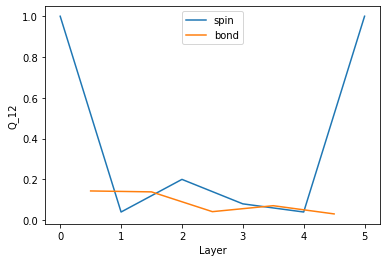

q_12  tensor([1.0000, 0.0400, 0.2000, 0.0800, 0.0400, 1.0000])
Q_12  tensor([0.1433, 0.1387, 0.0417, 0.0709, 0.0307])


In [174]:
q_12 = torch.tensor([q_12_S0, q_12_S1, q_12_S2,
     q_12_S3, q_12_S4, q_12_SL])
Q_12 = torch.tensor([Q_12_1, Q_12_2, Q_12_3,
     Q_12_4, Q_12_5])
i = [0,1,2,3,4,5]
plt.plot(i, q_12)
plt.xlabel('Layer')
plt.ylabel('q_12')

i = [0.5,1.5,2.5,3.5,4.5]
plt.plot(i, Q_12)
plt.xlabel('Layer')
plt.ylabel('Q_12')

plt.legend(['spin','bond'])
plt.show()

print('q_12 ',q_12)
print('Q_12 ',Q_12)

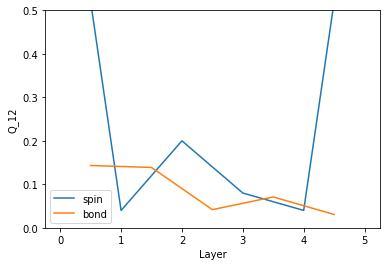

In [175]:
i = [0,1,2,3,4,5]
plt.plot(i, q_12)
plt.xlabel('Layer')
plt.ylabel('q_12')

i = [0.5,1.5,2.5,3.5,4.5]
plt.plot(i, Q_12)
plt.xlabel('Layer')
plt.ylabel('Q_12')

plt.legend(['spin','bond'])

plt.ylim(0,0.5)
plt.show()

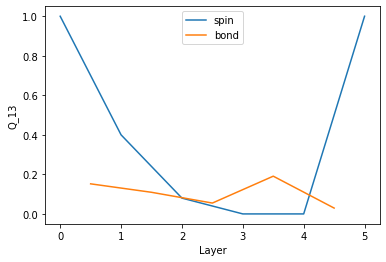

q_13  tensor([1.0000, 0.4000, 0.0800, 0.0000, 0.0000, 1.0000])
Q_13  tensor([0.1522, 0.1094, 0.0549, 0.1909, 0.0296])


In [176]:
q_13 = torch.tensor([q_13_S0, q_13_S1, q_13_S2,
     q_13_S3, q_13_S4, q_13_SL])
Q_13 = torch.tensor([Q_13_1, Q_13_2, Q_13_3,
     Q_13_4, Q_13_5])
i = [0,1,2,3,4,5]
plt.plot(i, q_13)
plt.xlabel('Layer')
plt.ylabel('q_13')

i = [0.5,1.5,2.5,3.5,4.5]
plt.plot(i, Q_13)
plt.xlabel('Layer')
plt.ylabel('Q_13')

plt.legend(['spin','bond'])
plt.show()

print('q_13 ',q_13)
print('Q_13 ',Q_13)

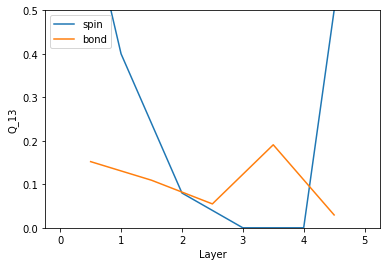

In [177]:
i = [0,1,2,3,4,5]
plt.plot(i, q_13)
plt.xlabel('Layer')
plt.ylabel('q_13')

i = [0.5,1.5,2.5,3.5,4.5]
plt.plot(i, Q_13)
plt.xlabel('Layer')
plt.ylabel('Q_13')

plt.legend(['spin','bond'])

plt.ylim(0,0.5)
plt.show()

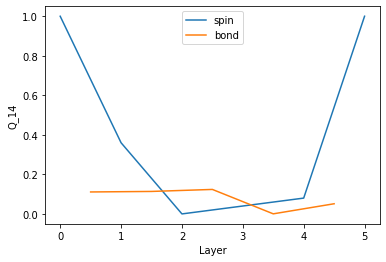

q_14  tensor([1.0000, 0.3600, 0.0000, 0.0400, 0.0800, 1.0000])
Q_14  tensor([0.1111, 0.1137, 0.1239, 0.0004, 0.0514])


In [178]:
q_14 = torch.tensor([q_14_S0, q_14_S1, q_14_S2,
     q_14_S3, q_14_S4, q_14_SL])
Q_14 = torch.tensor([Q_14_1, Q_14_2, Q_14_3,
     Q_14_4, Q_14_5])
i = [0,1,2,3,4,5]
plt.plot(i, q_14)
plt.xlabel('Layer')
plt.ylabel('q_14')

i = [0.5,1.5,2.5,3.5,4.5]
plt.plot(i, Q_14)
plt.xlabel('Layer')
plt.ylabel('Q_14')

plt.legend(['spin','bond'])
plt.show()

print('q_14 ',q_14)
print('Q_14 ',Q_14)

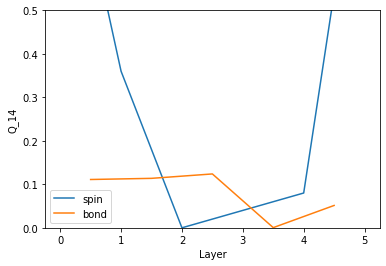

In [179]:
i = [0,1,2,3,4,5]
plt.plot(i, q_14)
plt.xlabel('Layer')
plt.ylabel('q_14')

i = [0.5,1.5,2.5,3.5,4.5]
plt.plot(i, Q_14)
plt.xlabel('Layer')
plt.ylabel('Q_14')

plt.legend(['spin','bond'])

plt.ylim(0,0.5)
plt.show()

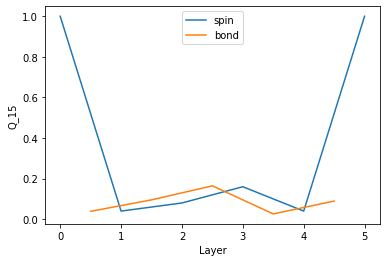

q_15  tensor([1.0000, 0.0400, 0.0800, 0.1600, 0.0400, 1.0000])
Q_15  tensor([0.0388, 0.0953, 0.1644, 0.0261, 0.0894])


In [180]:
q_15 = torch.tensor([q_15_S0, q_15_S1, q_15_S2,
     q_15_S3, q_15_S4, q_15_SL])
Q_15 = torch.tensor([Q_15_1, Q_15_2, Q_15_3,
     Q_15_4, Q_15_5])
i = [0,1,2,3,4,5]
plt.plot(i, q_15)
plt.xlabel('Layer')
plt.ylabel('q_15')

i = [0.5,1.5,2.5,3.5,4.5]
plt.plot(i, Q_15)
plt.xlabel('Layer')
plt.ylabel('Q_15')

plt.legend(['spin','bond'])
plt.show()

print('q_15 ',q_15)
print('Q_15 ',Q_15)

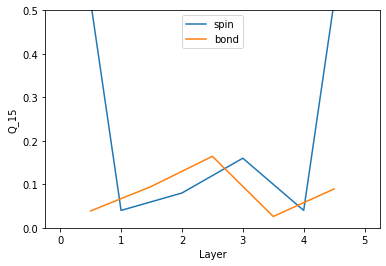

In [181]:
i = [0,1,2,3,4,5]
plt.plot(i, q_15)
plt.xlabel('Layer')
plt.ylabel('q_15')

i = [0.5,1.5,2.5,3.5,4.5]
plt.plot(i, Q_15)
plt.xlabel('Layer')
plt.ylabel('Q_15')

plt.legend(['spin','bond'])

plt.ylim(0,0.5)
plt.show()

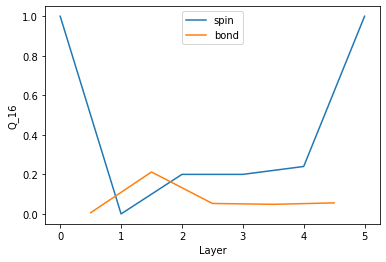

q_16  tensor([1.0000, 0.0000, 0.2000, 0.2000, 0.2400, 1.0000])
Q_16  tensor([0.0061, 0.2122, 0.0529, 0.0485, 0.0559])


In [182]:
q_16 = torch.tensor([q_16_S0, q_16_S1, q_16_S2,
     q_16_S3, q_16_S4, q_16_SL])
Q_16 = torch.tensor([Q_16_1, Q_16_2, Q_16_3,
     Q_16_4, Q_16_5])
i = [0,1,2,3,4,5]
plt.plot(i, q_16)
plt.xlabel('Layer')
plt.ylabel('q_16')

i = [0.5,1.5,2.5,3.5,4.5]
plt.plot(i, Q_16)
plt.xlabel('Layer')
plt.ylabel('Q_16')

plt.legend(['spin','bond'])
plt.show()

print('q_16 ',q_16)
print('Q_16 ',Q_16)

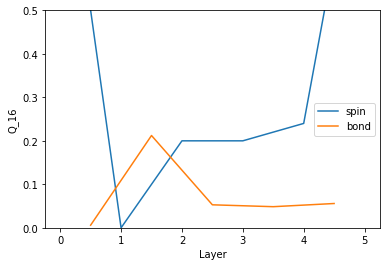

In [183]:
i = [0,1,2,3,4,5]
plt.plot(i, q_16)
plt.xlabel('Layer')
plt.ylabel('q_16')

i = [0.5,1.5,2.5,3.5,4.5]
plt.plot(i, Q_16)
plt.xlabel('Layer')
plt.ylabel('Q_16')

plt.legend(['spin','bond'])

plt.ylim(0,0.5)
plt.show()

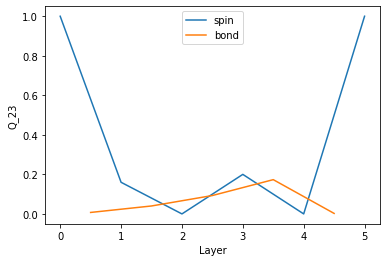

q_23  tensor([1.0000, 0.1600, 0.0000, 0.2000, 0.0000, 1.0000])
Q_23  tensor([0.0075, 0.0402, 0.0930, 0.1734, 0.0025])


In [184]:
q_23 = torch.tensor([q_23_S0, q_23_S1, q_23_S2,
     q_23_S3, q_23_S4, q_23_SL])
Q_23 = torch.tensor([Q_23_1, Q_23_2, Q_23_3,
     Q_23_4, Q_23_5])
i = [0,1,2,3,4,5]
plt.plot(i, q_23)
plt.xlabel('Layer')
plt.ylabel('q_23')

i = [0.5,1.5,2.5,3.5,4.5]
plt.plot(i, Q_23)
plt.xlabel('Layer')
plt.ylabel('Q_23')

plt.legend(['spin','bond'])
plt.show()

print('q_23 ',q_23)
print('Q_23 ',Q_23)

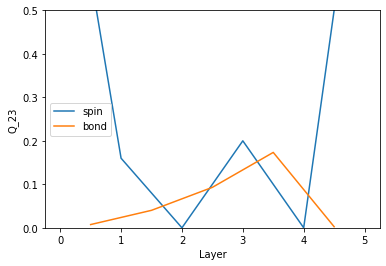

In [185]:
i = [0,1,2,3,4,5]
plt.plot(i, q_23)
plt.xlabel('Layer')
plt.ylabel('q_23')

i = [0.5,1.5,2.5,3.5,4.5]
plt.plot(i, Q_23)
plt.xlabel('Layer')
plt.ylabel('Q_23')

plt.legend(['spin','bond'])

plt.ylim(0,0.5)
plt.show()

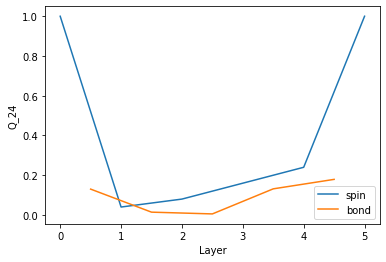

q_24  tensor([1.0000, 0.0400, 0.0800, 0.1600, 0.2400, 1.0000])
Q_24  tensor([0.1301, 0.0142, 0.0053, 0.1315, 0.1792])


In [186]:
q_24 = torch.tensor([q_24_S0, q_24_S1, q_24_S2,
     q_24_S3, q_24_S4, q_24_SL])
Q_24 = torch.tensor([Q_24_1, Q_24_2, Q_24_3,
     Q_24_4, Q_24_5])
i = [0,1,2,3,4,5]
plt.plot(i, q_24)
plt.xlabel('Layer')
plt.ylabel('q_24')

i = [0.5,1.5,2.5,3.5,4.5]
plt.plot(i, Q_24)
plt.xlabel('Layer')
plt.ylabel('Q_24')

plt.legend(['spin','bond'])
plt.show()

print('q_24 ',q_24)
print('Q_24 ',Q_24)

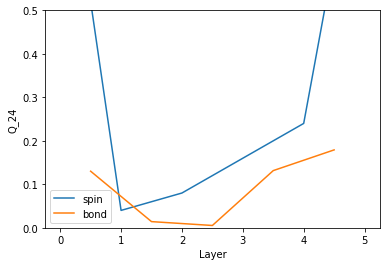

In [187]:
i = [0,1,2,3,4,5]
plt.plot(i, q_24)
plt.xlabel('Layer')
plt.ylabel('q_24')

i = [0.5,1.5,2.5,3.5,4.5]
plt.plot(i, Q_24)
plt.xlabel('Layer')
plt.ylabel('Q_24')

plt.legend(['spin','bond'])

plt.ylim(0,0.5)
plt.show()

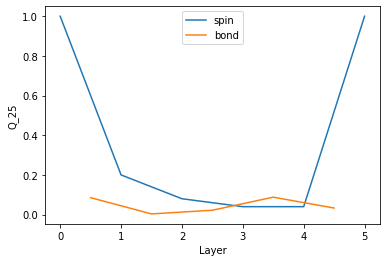

q_25  tensor([1.0000, 0.2000, 0.0800, 0.0400, 0.0400, 1.0000])
Q_25  tensor([0.0854, 0.0035, 0.0221, 0.0879, 0.0331])


In [188]:
q_25 = torch.tensor([q_25_S0, q_25_S1, q_25_S2,
     q_25_S3, q_25_S4, q_25_SL])
Q_25 = torch.tensor([Q_25_1, Q_25_2, Q_25_3,
     Q_25_4, Q_25_5])
i = [0,1,2,3,4,5]
plt.plot(i, q_25)
plt.xlabel('Layer')
plt.ylabel('q_25')

i = [0.5,1.5,2.5,3.5,4.5]
plt.plot(i, Q_25)
plt.xlabel('Layer')
plt.ylabel('Q_25')

plt.legend(['spin','bond'])
plt.show()

print('q_25 ',q_25)
print('Q_25 ',Q_25)

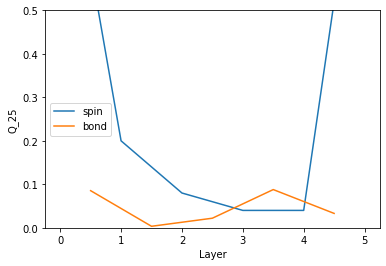

In [189]:
i = [0,1,2,3,4,5]
plt.plot(i, q_25)
plt.xlabel('Layer')
plt.ylabel('q_25')

i = [0.5,1.5,2.5,3.5,4.5]
plt.plot(i, Q_25)
plt.xlabel('Layer')
plt.ylabel('Q_25')

plt.legend(['spin','bond'])

plt.ylim(0,0.5)
plt.show()

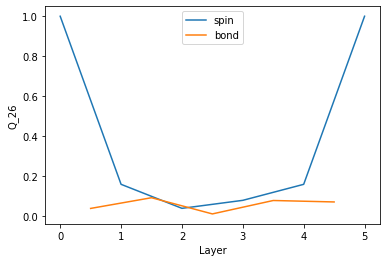

q_26  tensor([1.0000, 0.1600, 0.0400, 0.0800, 0.1600, 1.0000])
Q_26  tensor([0.0396, 0.0931, 0.0121, 0.0792, 0.0719])


In [190]:
q_26 = torch.tensor([q_26_S0, q_26_S1, q_26_S2,
     q_26_S3, q_26_S4, q_26_SL])
Q_26 = torch.tensor([Q_26_1, Q_26_2, Q_26_3,
     Q_26_4, Q_26_5])
i = [0,1,2,3,4,5]
plt.plot(i, q_26)
plt.xlabel('Layer')
plt.ylabel('q_26')

i = [0.5,1.5,2.5,3.5,4.5]
plt.plot(i, Q_26)
plt.xlabel('Layer')
plt.ylabel('Q_26')

plt.legend(['spin','bond'])
plt.show()

print('q_26 ',q_26)
print('Q_26 ',Q_26)

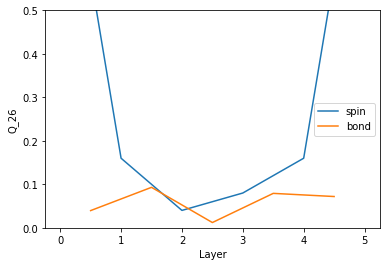

In [191]:
i = [0,1,2,3,4,5]
plt.plot(i, q_26)
plt.xlabel('Layer')
plt.ylabel('q_26')

i = [0.5,1.5,2.5,3.5,4.5]
plt.plot(i, Q_26)
plt.xlabel('Layer')
plt.ylabel('Q_26')

plt.legend(['spin','bond'])

plt.ylim(0,0.5)
plt.show()

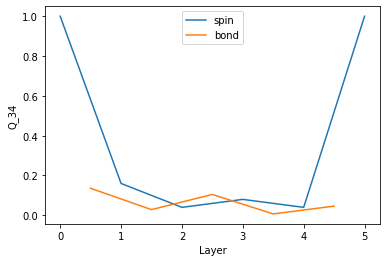

q_34  tensor([1.0000, 0.1600, 0.0400, 0.0800, 0.0400, 1.0000])
Q_34  tensor([0.1355, 0.0287, 0.1048, 0.0070, 0.0462])


In [192]:
q_34 = torch.tensor([q_34_S0, q_34_S1, q_34_S2,
     q_34_S3, q_34_S4, q_34_SL])
Q_34 = torch.tensor([Q_34_1, Q_34_2, Q_34_3,
     Q_34_4, Q_34_5])
i = [0,1,2,3,4,5]
plt.plot(i, q_34)
plt.xlabel('Layer')
plt.ylabel('q_34')

i = [0.5,1.5,2.5,3.5,4.5]
plt.plot(i, Q_34)
plt.xlabel('Layer')
plt.ylabel('Q_34')

plt.legend(['spin','bond'])
plt.show()

print('q_34 ',q_34)
print('Q_34 ',Q_34)

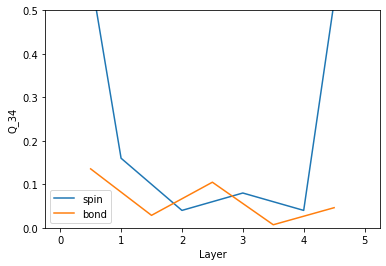

In [193]:
i = [0,1,2,3,4,5]
plt.plot(i, q_34)
plt.xlabel('Layer')
plt.ylabel('q_34')

i = [0.5,1.5,2.5,3.5,4.5]
plt.plot(i, Q_34)
plt.xlabel('Layer')
plt.ylabel('Q_34')

plt.legend(['spin','bond'])

plt.ylim(0,0.5)
plt.show()

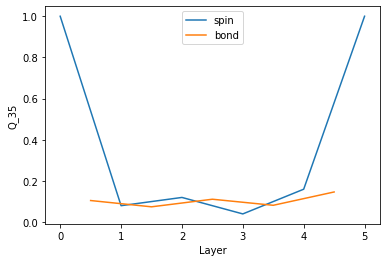

q_35  tensor([1.0000, 0.0800, 0.1200, 0.0400, 0.1600, 1.0000])
Q_35  tensor([0.1050, 0.0745, 0.1113, 0.0819, 0.1466])


In [194]:
q_35 = torch.tensor([q_35_S0, q_35_S1, q_35_S2,
     q_35_S3, q_35_S4, q_35_SL])
Q_35 = torch.tensor([Q_35_1, Q_35_2, Q_35_3,
     Q_35_4, Q_35_5])
i = [0,1,2,3,4,5]
plt.plot(i, q_35)
plt.xlabel('Layer')
plt.ylabel('q_35')

i = [0.5,1.5,2.5,3.5,4.5]
plt.plot(i, Q_35)
plt.xlabel('Layer')
plt.ylabel('Q_35')

plt.legend(['spin','bond'])
plt.show()

print('q_35 ',q_35)
print('Q_35 ',Q_35)

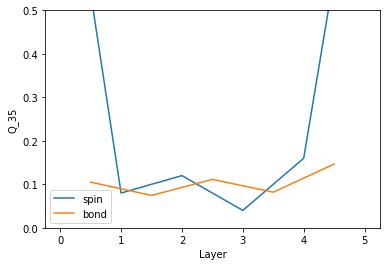

In [195]:
i = [0,1,2,3,4,5]
plt.plot(i, q_35)
plt.xlabel('Layer')
plt.ylabel('q_35')

i = [0.5,1.5,2.5,3.5,4.5]
plt.plot(i, Q_35)
plt.xlabel('Layer')
plt.ylabel('Q_35')

plt.legend(['spin','bond'])

plt.ylim(0,0.5)
plt.show()

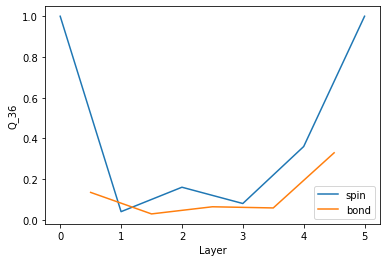

q_36  tensor([1.0000, 0.0400, 0.1600, 0.0800, 0.3600, 1.0000])
Q_36  tensor([0.1346, 0.0289, 0.0640, 0.0582, 0.3291])


In [196]:
q_36 = torch.tensor([q_36_S0, q_36_S1, q_36_S2,
     q_36_S3, q_36_S4, q_36_SL])
Q_36 = torch.tensor([Q_36_1, Q_36_2, Q_36_3,
     Q_36_4, Q_36_5])
i = [0,1,2,3,4,5]
plt.plot(i, q_36)
plt.xlabel('Layer')
plt.ylabel('q_36')

i = [0.5,1.5,2.5,3.5,4.5]
plt.plot(i, Q_36)
plt.xlabel('Layer')
plt.ylabel('Q_36')

plt.legend(['spin','bond'])
plt.show()

print('q_36 ',q_36)
print('Q_36 ',Q_36)

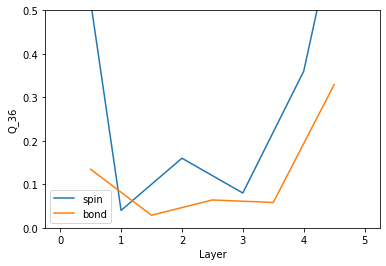

In [197]:
i = [0,1,2,3,4,5]
plt.plot(i, q_36)
plt.xlabel('Layer')
plt.ylabel('q_36')

i = [0.5,1.5,2.5,3.5,4.5]
plt.plot(i, Q_36)
plt.xlabel('Layer')
plt.ylabel('Q_36')

plt.legend(['spin','bond'])

plt.ylim(0,0.5)
plt.show()

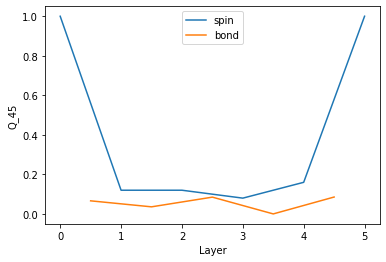

q_45  tensor([1.0000, 0.1200, 0.1200, 0.0800, 0.1600, 1.0000])
Q_45  tensor([0.0663, 0.0360, 0.0850, 0.0002, 0.0856])


In [198]:
q_45 = torch.tensor([q_45_S0, q_45_S1, q_45_S2,
     q_45_S3, q_45_S4, q_45_SL])
Q_45 = torch.tensor([Q_45_1, Q_45_2, Q_45_3,
     Q_45_4, Q_45_5])
i = [0,1,2,3,4,5]
plt.plot(i, q_45)
plt.xlabel('Layer')
plt.ylabel('q_45')

i = [0.5,1.5,2.5,3.5,4.5]
plt.plot(i, Q_45)
plt.xlabel('Layer')
plt.ylabel('Q_45')

plt.legend(['spin','bond'])
plt.show()

print('q_45 ',q_45)
print('Q_45 ',Q_45)

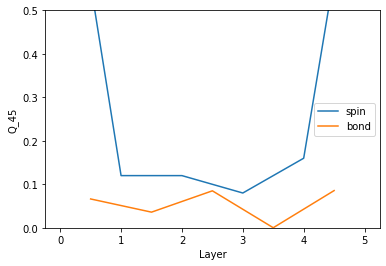

In [199]:
i = [0,1,2,3,4,5]
plt.plot(i, q_45)
plt.xlabel('Layer')
plt.ylabel('q_45')

i = [0.5,1.5,2.5,3.5,4.5]
plt.plot(i, Q_45)
plt.xlabel('Layer')
plt.ylabel('Q_45')

plt.legend(['spin','bond'])

plt.ylim(0,0.5)
plt.show()

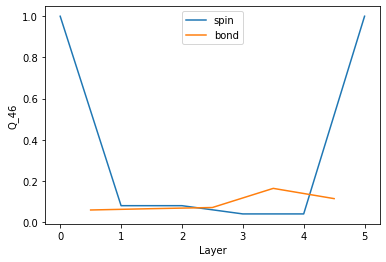

q_46  tensor([1.0000, 0.0800, 0.0800, 0.0400, 0.0400, 1.0000])
Q_46  tensor([0.0591, 0.0654, 0.0711, 0.1640, 0.1143])


In [200]:
q_46 = torch.tensor([q_46_S0, q_46_S1, q_46_S2,
     q_46_S3, q_46_S4, q_46_SL])
Q_46 = torch.tensor([Q_46_1, Q_46_2, Q_46_3,
     Q_46_4, Q_46_5])
i = [0,1,2,3,4,5]
plt.plot(i, q_46)
plt.xlabel('Layer')
plt.ylabel('q_46')

i = [0.5,1.5,2.5,3.5,4.5]
plt.plot(i, Q_46)
plt.xlabel('Layer')
plt.ylabel('Q_46')

plt.legend(['spin','bond'])
plt.show()

print('q_46 ',q_46)
print('Q_46 ',Q_46)

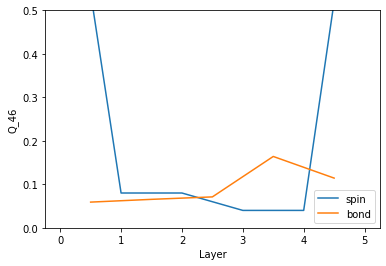

In [201]:
i = [0,1,2,3,4,5]
plt.plot(i, q_46)
plt.xlabel('Layer')
plt.ylabel('q_46')

i = [0.5,1.5,2.5,3.5,4.5]
plt.plot(i, Q_46)
plt.xlabel('Layer')
plt.ylabel('Q_46')

plt.legend(['spin','bond'])

plt.ylim(0,0.5)
plt.show()

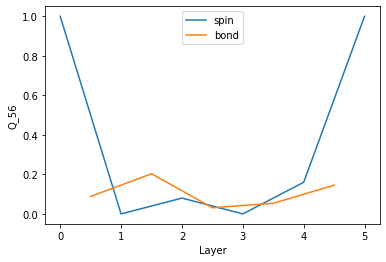

q_56  tensor([1.0000, 0.0000, 0.0800, 0.0000, 0.1600, 1.0000])
Q_56  tensor([0.0882, 0.2033, 0.0312, 0.0538, 0.1452])


In [202]:
q_56 = torch.tensor([q_56_S0, q_56_S1, q_56_S2,
     q_56_S3, q_56_S4, q_56_SL])
Q_56 = torch.tensor([Q_56_1, Q_56_2, Q_56_3,
     Q_56_4, Q_56_5])
i = [0,1,2,3,4,5]
plt.plot(i, q_56)
plt.xlabel('Layer')
plt.ylabel('q_56')

i = [0.5,1.5,2.5,3.5,4.5]
plt.plot(i, Q_56)
plt.xlabel('Layer')
plt.ylabel('Q_56')

plt.legend(['spin','bond'])
plt.show()

print('q_56 ',q_56)
print('Q_56 ',Q_56)

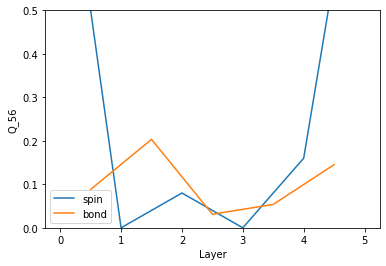

In [203]:
i = [0,1,2,3,4,5]
plt.plot(i, q_56)
plt.xlabel('Layer')
plt.ylabel('q_56')

i = [0.5,1.5,2.5,3.5,4.5]
plt.plot(i, Q_56)
plt.xlabel('Layer')
plt.ylabel('Q_56')

plt.legend(['spin','bond'])

plt.ylim(0,0.5)
plt.show()